## Anexa 4. Cod sursa - Aplicatia 4 - Retea LSTM
## Predictie viteza de referinta vant
#### Importare module

In [1]:
import time
import os
import math
import pickle
import pandas as pd
import numpy as np
import numpy
import datetime as dt
import seaborn as sns
import scipy
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.models import load_model
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, Image
# %matplotlib inline

sns.set_style("darkgrid")
seed = 314159
np.random.seed(seed)

Using TensorFlow backend.


### Incarcare set de date si previzualizare

In [2]:
database = pd.read_csv("in_vant_constanta.csv",skipinitialspace=True)
print("Primele 3 intrari")
display(database.head(3))
print("Ultimele 3 intrari")
display(database.tail(3))
print('Previzualizare set de date')
print('Dimensiuni set de date initial=',database.shape)

Primele 3 intrari


,YEARMODA,TEMP,WDSP,MXSPD
0,19520101,41.5,3.0,6.0
1,19520102,40.5,3.4,9.9
2,19520103,40.5,1.5,4.1


Ultimele 3 intrari


,YEARMODA,TEMP,WDSP,MXSPD
21304,20180602,68.3,3.9,7.8
21305,20180603,68.1,3.8,7.8
21306,20180604,67.9,2.5,3.9


Dimensiuni set de date initial= (21307, 4)


#### Legenda
TEMP = Mean temperature for the day in degrees Fahrenheit to tenths.  Missing = 9999.9 </br>
MXSPD= Maximum sustained wind speed reported for the day in knots to tenths. Missing = 999.9</br>
WDSP = Mean wind speed for the day in knots to tenths.  Missing = 999.9</br>

### Prelucrare set de date
#### Ignorarea intrarilor incomplete

In [3]:
database.replace(9999.9, np.nan,inplace=True)
database.replace(999.9, np.nan,inplace=True)
database.dropna(inplace=True)
print('Dimensiuni set de date final=',database.shape)

Dimensiuni set de date final= (21237, 4)


#### Transformare unitati de masura in grade Celsius si m/s

In [4]:
database["TEMP"] = (database["TEMP"]-32)*5/9
database["WDSP"] = database["WDSP"]*0.514444
database["MXSPD"] = database["MXSPD"]*0.51444
database=database.round(1)
database["timestamp"]=pd.to_datetime(database["YEARMODA"], format='%Y%m%d', errors='ignore')
database.drop(["YEARMODA",],axis=1,inplace=True)
database.set_index("timestamp", inplace = True)
display(database.head())

,TEMP,WDSP,MXSPD
timestamp,,,
1952-01-01,5.3,1.5,3.1
1952-01-02,4.7,1.7,5.1
1952-01-03,4.7,0.8,2.1
1952-01-04,7.3,2.8,4.1
1952-01-06,1.0,3.6,6.2


#### Matricea de corelatie

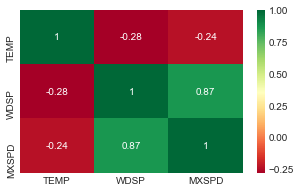

In [5]:
plt.subplots(figsize=(5, 3))
sns.heatmap(database.corr(), annot=True, cmap="RdYlGn");

### Previzualizare grafica set de date

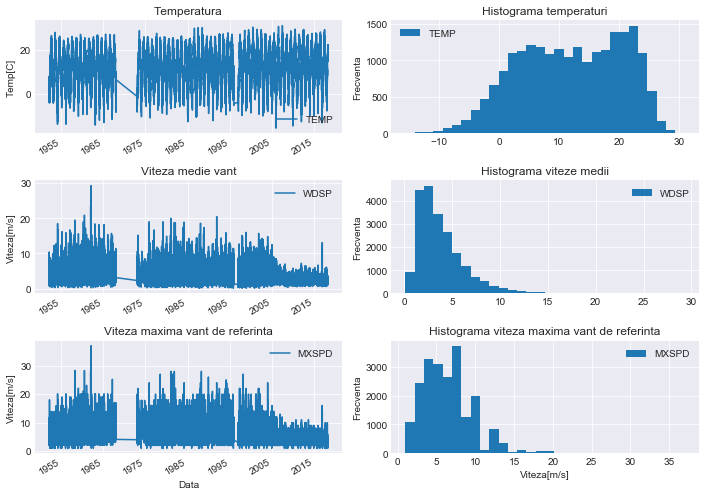

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10, 7))
ax=database.plot(y='TEMP', ax=axes[0,0],title='Temperatura')
ax.set_xlabel("")
ax.set_ylabel("Temp[C]")
plt.tight_layout()
ax=database.plot.hist(y='TEMP',bins=30,ax=axes[0,1],title='Histograma temperaturi')
ax.set_xlabel("")
ax.set_ylabel("Frecventa")
plt.tight_layout()
ax=database.plot(y='WDSP',ax=axes[1,0],title='Viteza medie vant')
ax.set_xlabel("")
ax.set_ylabel("Viteza[m/s]")
plt.tight_layout()
ax=database.plot.hist(y='WDSP',bins=30,ax=axes[1,1],title='Histograma viteze medii')
ax.set_xlabel("")
ax.set_ylabel("Frecventa")
plt.tight_layout()
ax=database.plot(y='MXSPD',ax=axes[2,0],title='Viteza maxima vant de referinta')
ax.set_xlabel("Data")
ax.set_ylabel("Viteza[m/s]")
plt.tight_layout()
ax=database.plot.hist(y='MXSPD',bins=30,ax=axes[2,1],title='Histograma viteza maxima vant de referinta')
ax.set_xlabel("Viteza[m/s]")
ax.set_ylabel("Frecventa");

#### Se observa lipsa datelor intre 19671231 - 19730101, se vor utiliza in continuare doar datele din 19730101.

### Vizualizare grafica set date final

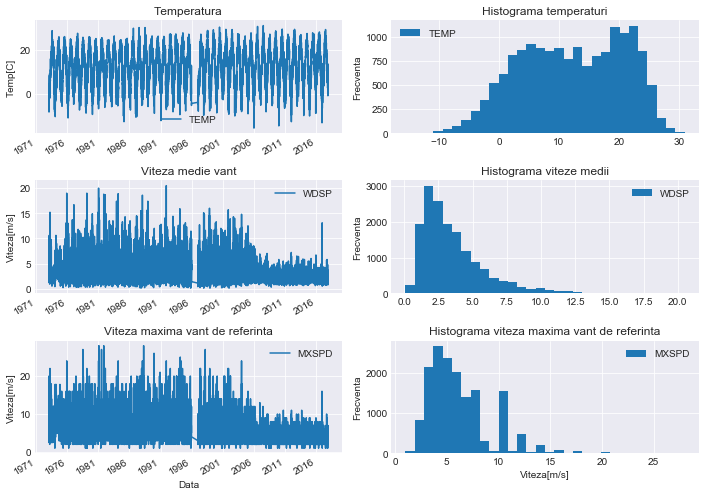

In [7]:
slice_i = pd.to_datetime('19730101', format='%Y%m%d', errors='ignore')
database=database[slice_i:]
slice_i2 = pd.to_datetime('20171231', format='%Y%m%d', errors='ignore')
database=database[:slice_i2]
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10, 7))
ax=database.plot(y='TEMP', ax=axes[0,0],title='Temperatura')
ax.set_xlabel("")
ax.set_ylabel("Temp[C]")
plt.tight_layout()
ax=database.plot.hist(y='TEMP',bins=30,ax=axes[0,1],title='Histograma temperaturi')
ax.set_xlabel("")
ax.set_ylabel("Frecventa")
plt.tight_layout()
ax=database.plot(y='WDSP',ax=axes[1,0],title='Viteza medie vant')
ax.set_xlabel("")
ax.set_ylabel("Viteza[m/s]")
plt.tight_layout()
ax=database.plot.hist(y='WDSP',bins=30,ax=axes[1,1],title='Histograma viteze medii')
ax.set_xlabel("")
ax.set_ylabel("Frecventa")
plt.tight_layout()
ax=database.plot(y='MXSPD',ax=axes[2,0],title='Viteza maxima vant de referinta')
ax.set_xlabel("Data")
ax.set_ylabel("Viteza[m/s]")
plt.tight_layout()
ax=database.plot.hist(y='MXSPD',bins=30,ax=axes[2,1],title='Histograma viteza maxima vant de referinta')
ax.set_xlabel("Viteza[m/s]")
ax.set_ylabel("Frecventa");

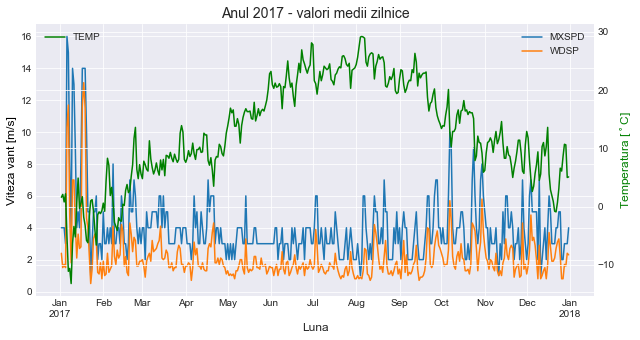

In [8]:
ax=database['2017']['MXSPD'].plot(figsize=(10,5),fontsize =10, legend=True)
ax=database['2017']['WDSP'].plot(figsize=(10,5),fontsize =10,legend=True)
ax.set_title("Anul 2017 - valori medii zilnice",fontsize=14)
ax.set_xlabel("Luna",fontsize=12)
ax.set_ylabel("Viteza vant [m/s]",fontsize=12,color='k')
ax2 = ax.twinx()
ax2=database['2017']['TEMP'].plot(figsize=(10,5),fontsize =10,color='g')
ax2.legend(loc='upper left')
ax2.set_ylabel("Temperatura [$^\circ$C]",fontsize=12,color='g');

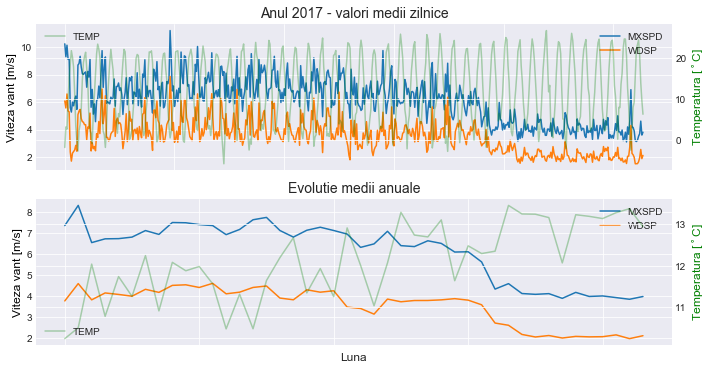

In [11]:
coun=database
coun['Month']=coun.index.map(lambda x: x.strftime('%Y-%m'))
coun['Month_only']=coun.index.map(lambda x: x.strftime('%m'))
c_group_month = coun.groupby('Month').mean()

fig = plt.figure(figsize=(15, 10))
ax=plt.subplot(2, 1, 1)
ax=c_group_month['MXSPD'].plot(figsize=(10,5),fontsize =10, legend=True)
ax=c_group_month['WDSP'].plot(figsize=(10,5),fontsize =10,legend=True)
ax.set_title("Anul 2017 - valori medii zilnice",fontsize=14)
ax.set_xlabel("Luna",fontsize=12)
ax.set_ylabel("Viteza vant [m/s]",fontsize=12,color='k')
ax2 = ax.twinx()
ax2=c_group_month['TEMP'].plot(figsize=(10,5),fontsize =10,color='g',alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_ylabel("Temperatura [$^\circ$C]",fontsize=12,color='g')
plt.tight_layout()

coun['Year']=coun.index.map(lambda x: x.strftime('%Y'))
c_group_year = coun.groupby('Year').mean()

ax=plt.subplot(2, 1, 2)
ax=c_group_year['MXSPD'].plot(figsize=(10,5),fontsize =10, legend=True)
ax=c_group_year['WDSP'].plot(figsize=(10,5),fontsize =10,legend=True)
ax.set_title("Evolutie medii anuale",fontsize=14)
ax.set_xlabel("Luna",fontsize=12)
ax.set_ylabel("Viteza vant [m/s]",fontsize=12,color='k')
ax2 = ax.twinx()
ax2=c_group_year['TEMP'].plot(figsize=(10,5),fontsize =10,color='g',alpha=0.3)
ax2.legend(loc='lower left')
ax2.set_ylabel("Temperatura [$^\circ$C]",fontsize=12,color='g');

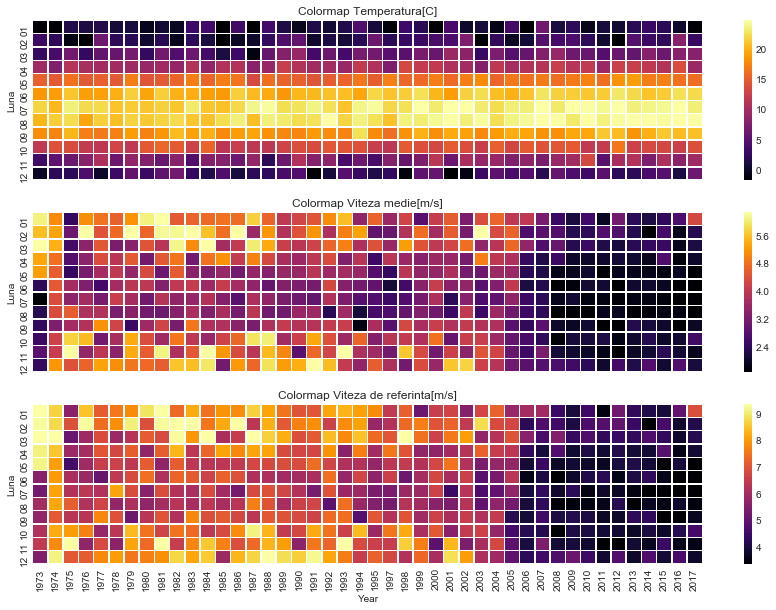

In [12]:
fig = plt.figure(figsize=(15, 10))
ax=plt.subplot(3, 1, 1)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only',
                                        columns = 'Year', values = 'TEMP')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Temperatura[C]",fontsize=12)
ax.set_xlabel("")
ax.set_xticks([])
ax.set_ylabel("Luna", fontsize=10)


ax=plt.subplot(3, 1, 2)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only', 
                                                columns = 'Year', values = 'WDSP')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
ax=sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Viteza medie[m/s]",fontsize=12)
ax.set_xlabel("")
ax.set_xticks([])
ax.set_ylabel("Luna", fontsize=10)

ax=plt.subplot(3, 1, 3)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only', 
                                        columns = 'Year', values = 'MXSPD')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
ax=sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Viteza de referinta[m/s]",fontsize=12)
# ax.set_xlabel("Ani")
ax.set_ylabel("Luna", fontsize=10);

### Pregatire date de anrenare si testare

### A. Retea LSTM - unidimensionala
#### Se va lua in considerare doar maximele anuale ale vitezei de referinta a vantului

In [13]:
numpy.random.seed(7)
K.clear_session()

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

df=coun.groupby('Year').max()
df=df.reset_index()
df=df.drop(columns=['Year','TEMP','WDSP','Month','Month_only'], inplace=False)
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train = dataset
look_back = 5
n_epochs = 1217
dropout=.05

trainX, trainY = create_dataset(train, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(36,return_sequences = True,input_shape=(1, look_back), dropout=dropout))
model.add(LSTM(18, return_sequences = True, dropout=dropout))
model.add(LSTM(9, return_sequences = False, dropout=dropout))
# model.add(Dense(9, activation='linear',kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=1, verbose=0)
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))

Scor: 1.58 RMSE


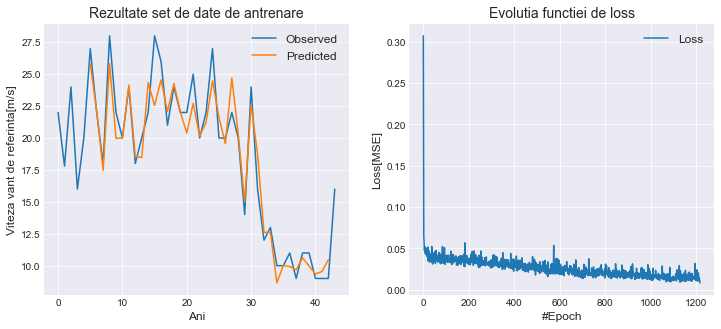

In [15]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform([trainY])
trainScore = math.sqrt(mean_squared_error(trainY_i[0], trainPredict[:,0]))
print('Scor: %.2f RMSE' % (trainScore))
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# plot baseline and predictions
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(scaler.inverse_transform(dataset),label='Observed')
plt.plot(trainPredictPlot,label='Predicted')
plt.title('Rezultate set de date de antrenare',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Loss')
plt.grid()
plt.xlabel('#Epoch',fontsize=12)
plt.ylabel('Loss[MSE]',fontsize=12)
plt.title('Evolutia functiei de loss',fontsize=14)
plt.grid()
plt.legend(fontsize=12);

#### Salvare model

In [ ]:
model_num = 3
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
model.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# del model

#### Incarcare model salvat

In [14]:
model_num = 2
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
model = load_model(nn_filename)
with open(hist_filename, 'rb') as handle:
    history = pickle.load(handle)

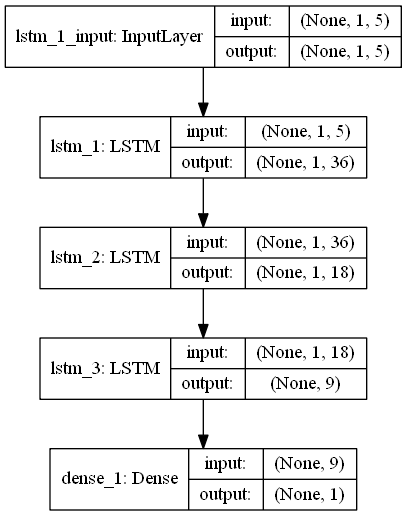

In [16]:
plot_model(model, to_file='keras_plot_model.png', show_shapes=True)
display(Image(filename='keras_plot_model.png', width=250))

In [17]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                       
    moving_test_window= trainX[-1,].reshape(1,1,look_back)
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) 
        preds_moving.append(preds_one_step[0,0]) 
        preds_one_step = preds_one_step.reshape(1,1,1) 
        moving_test_window = np.concatenate((moving_test_window, preds_one_step), axis=2)
        moving_test_window = moving_test_window[:,:,1:]
    
    return preds_moving

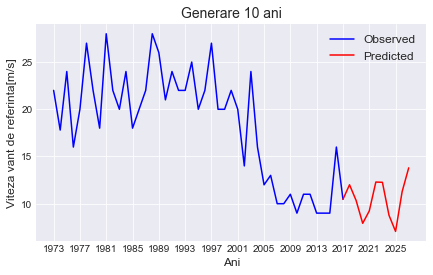

In [75]:
n_future_preds = 11
n_initial_obs = 1973
n_available = 44
n_final_obs = n_initial_obs + n_available
n_final = n_final_obs + n_future_preds
range_train = numpy.arange(n_initial_obs, n_final_obs, 1)
range_test = numpy.arange(range_train[-1:]+1,n_final,1)
range_final = numpy.arange(n_initial_obs, n_final, 1)

fig= plt.figure(figsize=(7,4))
preds_moving=moving_test_window_preds(n_future_preds)
dataset_train_u = np.array([i[0] for i in dataset])
pred_train_uni = scaler.inverse_transform(dataset_train_u.reshape(-1, 1))
dataset_test_uni = np.array(preds_moving)
pred_test_uni = scaler.inverse_transform(dataset_test_uni.reshape(-1, 1))
te_pl_y = np.concatenate((pred_train_uni, pred_test_uni[0:1]), axis=0)
te_pl_x = np.concatenate((range_initial, range_test[0:1]), axis=0)
plt.plot(te_pl_x, te_pl_y, color='b',label='Observed')
plt.plot(range_test, pred_test_uni, color='r', label='Predicted')
plt.title('Generare 10 ani',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12);

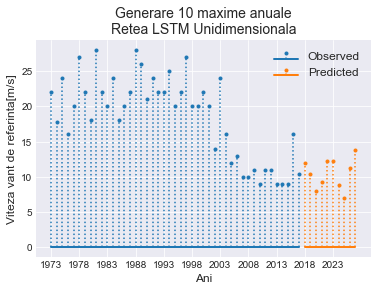

In [377]:
markerline, stemlines, baseline = plt.stem(te_pl_x, set_initial_uni, 'C0:',markerfmt='C0.', label='Observed')
plt.setp(baseline, color='C0', linewidth=2)
markerline, stemlines, baseline = plt.stem(range_test[1:], pred_test_uni[1:], 'C1:',markerfmt='C1.', label='Predicted')
plt.setp(baseline, color='C1', linewidth=2)
plt.title('Generare 10 maxime anuale\nRetea LSTM Unidimensionala',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.xticks(numpy.arange(n_initial_obs, n_final, 5))
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12);

In [227]:
flatten = lambda l: [item for sublist in l for item in sublist]
set_initial = flatten(te_pl_y)
set_predictie = flatten(pred_test_uni[1:])
set_final = np.concatenate((set_initial,set_predictie))
range_initial = te_pl_x
range_final = np.concatenate((te_pl_x,range_test[1:]))
# range_final_fine = np.arange(min(set_final),max(set_final),1)
range_final_fine = np.arange(5,30,1)

In [318]:
set_initial_uni = set_initial
set_predictie_uni = set_predictie
set_final_uni = set_final

#### Statistica set de date initial si final

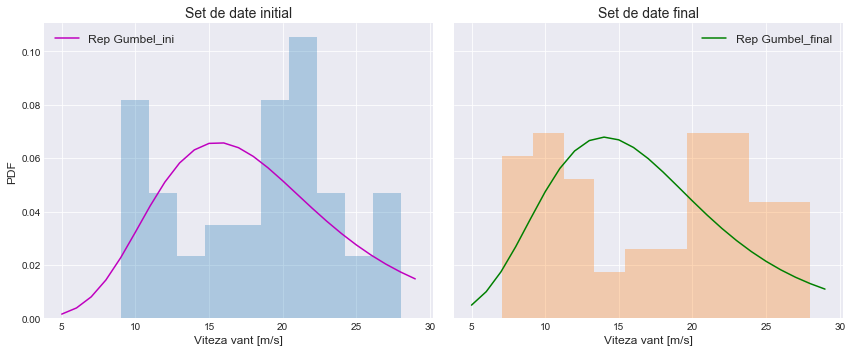

In [392]:
nbins=10
dist_name='gumbel_r'
dist_label='Rep Gumbel'
dist = getattr(scipy.stats, dist_name)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,5))


data=set_initial_uni
y, x = np.histogram(data, bins=nbins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

h = ax1.hist(data, bins=nbins, density=True, alpha=0.3)
param = dist.fit(data)
pdf_fitted = dist.pdf(range_final_fine, *param[:-2], loc=param[-2], scale=param[-1])
ax1.plot(range_final_fine, pdf_fitted, label=dist_label+'_ini', c='m')
ax1.legend(loc='best',fontsize=12)
ax1.set_title('Set de date initial',fontsize=14)
ax1.set_xlabel('Viteza vant [m/s]',fontsize=12)
ax1.set_ylabel('PDF',fontsize=12)
plt.tight_layout()
sumar_initial_uni = {'0_Set':'Initial_uni', '1_Mean': np.mean(data), 
                 '2_Std': np.std(data),'3_CV': np.std(data)/np.mean(data),
                 '4_Skew':dist.stats(param[0], param[1], moments='s').tolist(), 
                 '5_Kurt': dist.stats(param[0], param[1], moments='k').tolist(),
                '6_Gumbel_u':param[0],'7_Gumbel_alfa':param[1]}

data=set_final_uni
y, x = np.histogram(data, bins=nbins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
h = ax2.hist(data, bins=nbins, density=True, color='C1',alpha=0.3)
param = dist.fit(data)
pdf_fitted = dist.pdf(range_final_fine, *param[:-2], loc=param[-2], scale=param[-1])
ax2.plot(range_final_fine, pdf_fitted, label=dist_label+'_final', c='g')
ax2.legend(loc='best',fontsize=12)
ax2.set_title('Set de date final',fontsize=14)
ax2.set_xlabel('Viteza vant [m/s]',fontsize=12)
plt.tick_params(labelleft=False)
sumar_final_uni = {'0_Set':'Final_uni', '1_Mean': np.mean(data), 
                 '2_Std': np.std(data),'3_CV': np.std(data)/np.mean(data),
                 '4_Skew':dist.stats(param[0], param[1], moments='s').tolist(), 
                 '5_Kurt': dist.stats(param[0], param[1], moments='k').tolist(),
                '6_Gumbel_u':param[0],'7_Gumbel_alfa':param[1]}

### Comparatie cuantila 98%

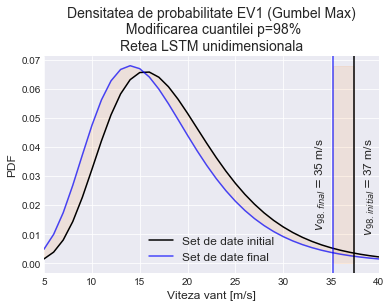

In [407]:
mu_1 , alfa_1 = sts.gumbel_r.fit(set_initial_uni)
mu_2 , alfa_2 = sts.gumbel_r.fit(set_final_uni)
x_range= np.arange(min(set_final_uni)-min(set_final_uni),max(set_final_uni)+30)
v98_initial = sts.gumbel_r.ppf(0.98, loc=mu_1, scale=alfa_1)
v98_final = sts.gumbel_r.ppf(0.98, loc=mu_2, scale=alfa_2)
pdf_fitted_initial = sts.gumbel_r.pdf(x_range, loc=mu_1, scale=alfa_1)
plt.plot(x_range,pdf_fitted_initial, label='Set de date initial',c='k')
pdf_fitted_final = sts.gumbel_r.pdf(x_range, loc=mu_2, scale=alfa_2)
plt.plot(x_range,pdf_fitted_final, label='Set de date final', c='b', alpha=0.7)
plt.axvline(v98_initial, c='k')
plt.axvline(v98_final, c='b', alpha= 0.7)
plt.text(v98_final-2, 0.04, '$v_{98.final}=$%i m/s'%v98_final, fontsize=12,rotation=90)
plt.text(v98_initial+1, 0.04, '$v_{98.initial}=$%i m/s'%v98_initial, fontsize=12,rotation=90)
plt.fill_between(x_range, pdf_fitted_initial, pdf_fitted_final, color='C1', alpha=0.1)
plt.fill((v98_final,v98_initial,v98_initial,v98_final), (0,0, max(pdf_fitted_final),max(pdf_fitted_final)), color='C1', alpha=0.1)
plt.xlim(5,40)
plt.title('Densitatea de probabilitate EV1 (Gumbel Max)\n Modificarea cuantilei p=98%\nRetea LSTM unidimensionala',fontsize=14)
plt.xlabel('Viteza vant [m/s]',fontsize=12)
plt.ylabel('PDF',fontsize=12)
plt.legend(fontsize=12);

### B. Retea LSTM - tridimensionala

Pe langa viteza de referinta vantului, reteaua va primi ca input si maximele anuale ale temperaturilor medii zilnice, cat si maximele anuale ale vitezei medii zilnice a vantului.

In [267]:
K.clear_session()
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
df=coun.groupby('Year').max()
df=df.reset_index()
df=df.drop(columns=['Year','Month','Month_only'], inplace=False)
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_temp = dataset[:,0].reshape(len(dataset[:,0]),1)
train_wdsp = dataset[:,1].reshape(len(dataset[:,1]),1)
train_mxspd = dataset[:,2].reshape(len(dataset[:,2]),1)
look_back = 5
n_epochs = 1444
dropout=.05

trainX_temp, trainY_temp = create_dataset(train_temp, look_back)
trainX_temp = numpy.reshape(trainX_temp, (trainX_temp.shape[0], 1, trainX_temp.shape[1]))
trainY_temp = trainY_temp.reshape(len(trainY_temp),1)

trainX_wdsp, trainY_wdsp = create_dataset(train_wdsp, look_back)
trainX_wdsp = numpy.reshape(trainX_wdsp, (trainX_wdsp.shape[0], 1, trainX_wdsp.shape[1]))
trainY_wdsp = trainY_wdsp.reshape(len(trainY_wdsp),1)

trainX_mxspd, trainY_mxspd = create_dataset(train_mxspd, look_back)
trainX_mxspd = numpy.reshape(trainX_mxspd, (trainX_mxspd.shape[0], 1, trainX_mxspd.shape[1]))
trainY_mxspd = trainY_mxspd.reshape(len(trainY_mxspd),1)

trainX = np.concatenate((trainX_temp,trainX_wdsp,trainX_mxspd),axis=1)
trainY = np.concatenate((trainY_temp,trainY_wdsp,trainY_mxspd),axis=1)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(36,return_sequences = True,input_shape=(3, look_back), dropout=dropout))
model.add(LSTM(18, return_sequences = True, dropout=dropout))
model.add(LSTM(9, return_sequences = False, dropout=dropout))
# model.add(Dense(9, activation='linear',kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=1, verbose=2)
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))

Scor: 1.36 RMSE


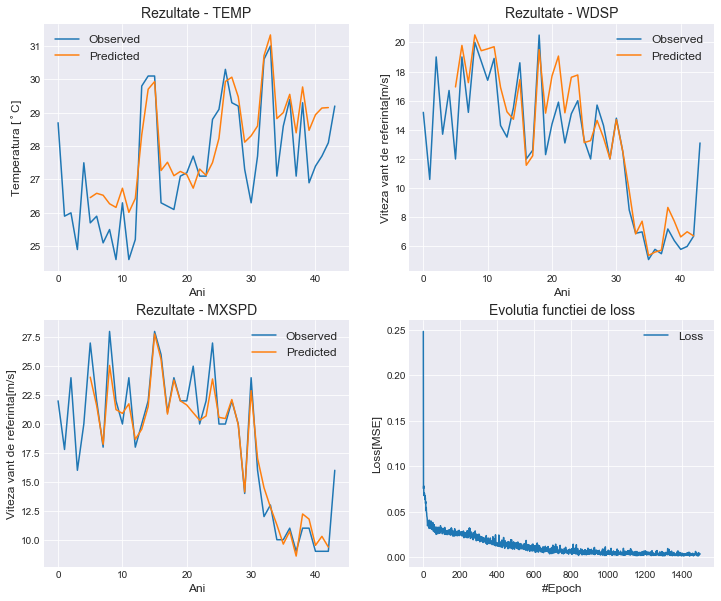

In [270]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform(trainY)
trainScore = math.sqrt(mean_squared_error(trainY_i, trainPredict))
print('Scor: %.2f RMSE' % (trainScore))
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

dataset_i = scaler.inverse_transform(dataset)
# plot baseline and predictions
fig = plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(dataset_i[:,0],label='Observed')
plt.plot(trainPredictPlot[:,0],label='Predicted')
plt.title('Rezultate - TEMP',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Temperatura [$^\circ$C]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,2)
plt.plot(dataset_i[:,1],label='Observed')
plt.plot(trainPredictPlot[:,1],label='Predicted')
plt.title('Rezultate - WDSP',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,3)
plt.plot(dataset_i[:,2],label='Observed')
plt.plot(trainPredictPlot[:,2],label='Predicted')
plt.title('Rezultate - MXSPD',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,4)
plt.plot(history['loss'], label='Loss')
plt.grid()
plt.xlabel('#Epoch',fontsize=12)
plt.ylabel('Loss[MSE]',fontsize=12)
plt.title('Evolutia functiei de loss',fontsize=14)
plt.grid()
plt.legend(fontsize=12);

In [272]:
index_min = np.argmin(history['loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)

Precizia ce mai buna se obtine pentru n_epochs= 1444


#### Salvare model

In [ ]:
model_num = 2
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_tridimensional.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_tridimensional.pickle')))
model.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# del model

#### Incarcare model salvat

In [268]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_tridimensional.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_tridimensional.pickle')))
model = load_model(nn_filename)
with open(hist_filename, 'rb') as handle:
    history = pickle.load(handle)

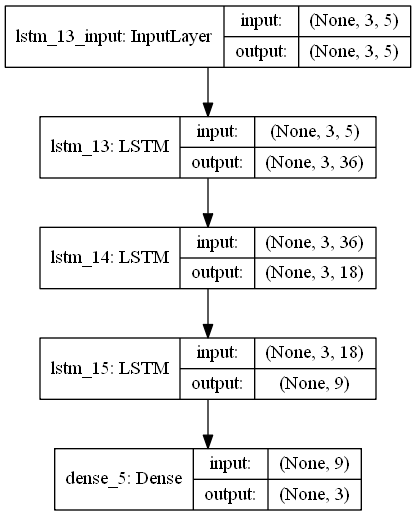

In [273]:
plot_model(model, to_file='keras_plot_model_tri.png', show_shapes=True)
display(Image(filename='keras_plot_model_tri.png', width=250))

In [274]:
def moving_test_window_preds_3(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                       
    moving_test_window= trainX[-2:-1,:,:].reshape(1,3,look_back)
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) 
        preds_moving.append(preds_one_step[0,:]) 
        preds_one_step = preds_one_step.reshape(1,3,1) 
        moving_test_window = np.concatenate((moving_test_window, preds_one_step), axis=2)
        moving_test_window = moving_test_window[:,:,1:]
    
    return preds_moving

In [302]:
n_future_preds = 11
n_initial_obs = 1973
n_available = 44
n_final_obs = n_initial_obs + n_available
n_final = n_final_obs + n_future_preds
range_train = numpy.arange(n_initial_obs, n_final_obs, 1)
range_test = numpy.arange(range_train[-1:]+1,n_final,1)
range_final = numpy.arange(n_initial_obs, n_final, 1)

preds_moving=moving_test_window_preds_3(n_future_preds)
pred_train_tri = scaler.inverse_transform(dataset)
dataset_test_tri = np.array(preds_moving)
pred_test_tri = scaler.inverse_transform(dataset_test_tri)
te_pl_y = np.concatenate((pred_train_tri, pred_test_tri[0:1,:]), axis=0)
te_pl_x = np.concatenate((range_initial, range_test[0:1]), axis=0)

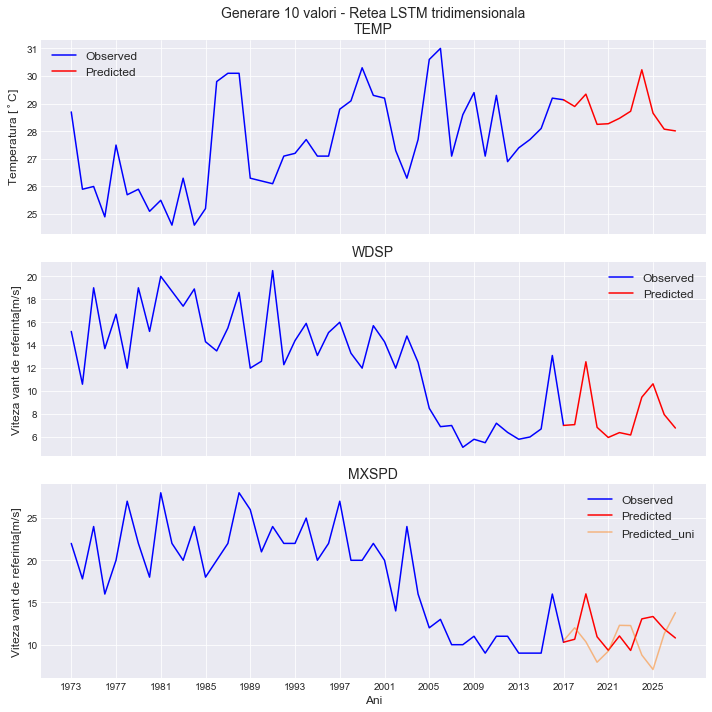

In [383]:
fig= plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(te_pl_x, te_pl_y[:,0], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,0], color='r',label='Predicted')
plt.title('Generare 10 valori - Retea LSTM tridimensionala\nTEMP',fontsize=14)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.tick_params(labelbottom=False)
plt.ylabel('Temperatura [$^\circ$C]',fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

plt.subplot(3,1,2)
plt.plot(te_pl_x, te_pl_y[:,1], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,1], color='r',label='Predicted')
plt.title('WDSP',fontsize=14)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.tick_params(labelbottom=False)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

plt.subplot(3,1,3)
plt.plot(te_pl_x, te_pl_y[:,2], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,2], color='r',label='Predicted')
plt.title('MXSPD',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.plot(range_test,pred_test_uni,color='C1',alpha=0.5,label='Predicted_uni')
plt.legend(fontsize=12)
plt.tight_layout()

In [319]:
set_initial = te_pl_y
set_predictie = pred_test_tri[1:]
set_final = np.concatenate((set_initial,set_predictie))
range_initial = te_pl_x
range_final = np.concatenate((te_pl_x,range_test[1:]))
# range_final_fine = np.arange(min(set_final),max(set_final),1)
range_final_fine = np.arange(5,30,1)

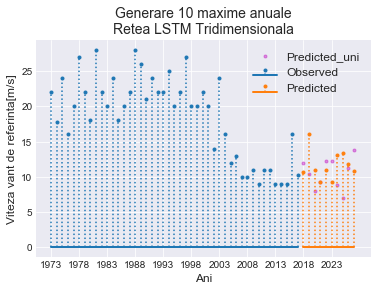

In [378]:
markerline, stemlines, baseline = plt.stem(te_pl_x, te_pl_y[:,2], 'C0:',markerfmt='C0.', label='Observed')
plt.setp(baseline, color='C0', linewidth=2)
markerline, stemlines, baseline = plt.stem(range_test[1:], set_predictie[:,2], 'C1:',markerfmt='C1.', label='Predicted')
plt.setp(baseline, color='C1', linewidth=2)
plt.scatter(range_test[1:], set_predictie_uni[:],marker='.', c='m', alpha=0.4, label='Predicted_uni')
plt.title('Generare 10 maxime anuale\nRetea LSTM Tridimensionala',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.xticks(numpy.arange(n_initial_obs, n_final, 5))
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12);

#### Statistica set de date initial si final

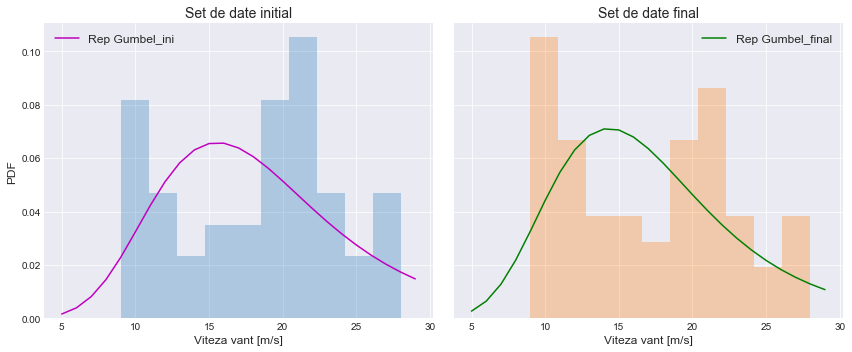

In [389]:
nbins=10
dist_name='gumbel_r'
dist_label='Rep Gumbel'
dist = getattr(scipy.stats, dist_name)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,5))

data=set_initial[:,2]
y, x = np.histogram(data, bins=nbins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

h = ax1.hist(data, bins=nbins, density=True, alpha=0.3)
param = dist.fit(data)
pdf_fitted = dist.pdf(range_final_fine, *param[:-2], loc=param[-2], scale=param[-1])
ax1.plot(range_final_fine, pdf_fitted, label=dist_label+'_ini', c='m')
ax1.legend(loc='best',fontsize=12)
ax1.set_title('Set de date initial',fontsize=14)
ax1.set_xlabel('Viteza vant [m/s]',fontsize=12)
ax1.set_ylabel('PDF',fontsize=12)
plt.tight_layout()
sumar_initial_tri = {'0_Set':'Initial', '1_Mean': np.mean(data), 
                 '2_Std': np.std(data),'3_CV': np.std(data)/np.mean(data),
                 '4_Skew':dist.stats(param[0], param[1], moments='s').tolist(), 
                 '5_Kurt': dist.stats(param[0], param[1], moments='k').tolist(),
                '6_Gumbel_u':param[0],'7_Gumbel_alfa':param[1]}

data=set_final[:,2]
y, x = np.histogram(data, bins=nbins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
h = ax2.hist(data, bins=nbins, density=True, color='C1',alpha=0.3)
param = dist.fit(data)
pdf_fitted = dist.pdf(range_final_fine, *param[:-2], loc=param[-2], scale=param[-1])
ax2.plot(range_final_fine, pdf_fitted, label=dist_label+'_final', c='g')
ax2.legend(loc='best',fontsize=12)
ax2.set_title('Set de date final',fontsize=14)
ax2.set_xlabel('Viteza vant [m/s]',fontsize=12)
plt.tick_params(labelleft=False)

sumar_final_tri = {'0_Set':'Final_tri', '1_Mean': np.mean(data), 
                 '2_Std': np.std(data),'3_CV': np.std(data)/np.mean(data),
                 '4_Skew':dist.stats(param[0], param[1], moments='s').tolist(), 
                 '5_Kurt': dist.stats(param[0], param[1], moments='k').tolist(),
                '6_Gumbel_u':param[0],'7_Gumbel_alfa':param[1]}

### Comparatie cuantila 98%

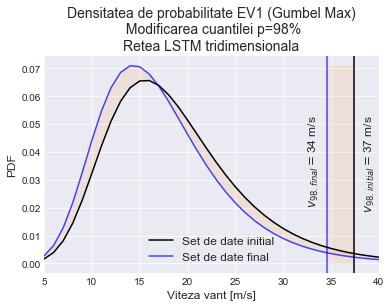

In [405]:
mu_1 , alfa_1 = sts.gumbel_r.fit(set_initial[:,2])
mu_2 , alfa_2 = sts.gumbel_r.fit(set_final[:,2])
# x_range= np.arange(min(set_final)-min(set_final),max(set_final)+200)
v98_initial = sts.gumbel_r.ppf(0.98, loc=mu_1, scale=alfa_1)
v98_final = sts.gumbel_r.ppf(0.98, loc=mu_2, scale=alfa_2)
pdf_fitted_initial = sts.gumbel_r.pdf(x_range, loc=mu_1, scale=alfa_1)
plt.plot(x_range,pdf_fitted_initial, label='Set de date initial',c='k')
pdf_fitted_final = sts.gumbel_r.pdf(x_range, loc=mu_2, scale=alfa_2)
plt.plot(x_range,pdf_fitted_final, label='Set de date final', c='b', alpha=0.7)
plt.axvline(v98_initial, c='k')
plt.axvline(v98_final, c='b', alpha= 0.7)
plt.text(v98_final-2, 0.05, '$v_{98.final}=$%i m/s'%v98_final, fontsize=12,rotation=90)
plt.text(v98_initial+1, 0.05, '$v_{98.initial}=$%i m/s'%v98_initial, fontsize=12,rotation=90)
plt.fill_between(x_range, pdf_fitted_initial, pdf_fitted_final, color='C1', alpha=0.1)
plt.fill((v98_final,v98_initial,v98_initial,v98_final), (0,0, max(pdf_fitted_final),max(pdf_fitted_final)), color='C1', alpha=0.1)
plt.xlim(5,40)
plt.title('Densitatea de probabilitate EV1 (Gumbel Max)\n Modificarea cuantilei p=98%\nRetea LSTM tridimensionala',fontsize=14)
plt.xlabel('Viteza vant [m/s]',fontsize=12)
plt.ylabel('PDF',fontsize=12)
plt.legend(fontsize=12);

In [395]:
Sumar_uni=pd.DataFrame.from_dict([sumar_initial_tri, sumar_final_uni, sumar_final_tri]).round(3)
Sumar_uni

,0_Set,1_Mean,2_Std,3_CV,4_Skew,5_Kurt,6_Gumbel_u,7_Gumbel_alfa
0,Initial,18.535,5.809,0.313,1.14,2.4,15.559,5.588
1,Final_uni,17.077,6.161,0.361,1.14,2.4,14.027,5.418
2,Final_tri,17.280,5.948,0.344,1.14,2.4,14.345,5.172
